In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import average_precision_score

%matplotlib inline

In [44]:
data = pd.read_csv("input/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
data['Hour'] = data["Time"].apply(lambda x : divmod(x, 3600)[0])

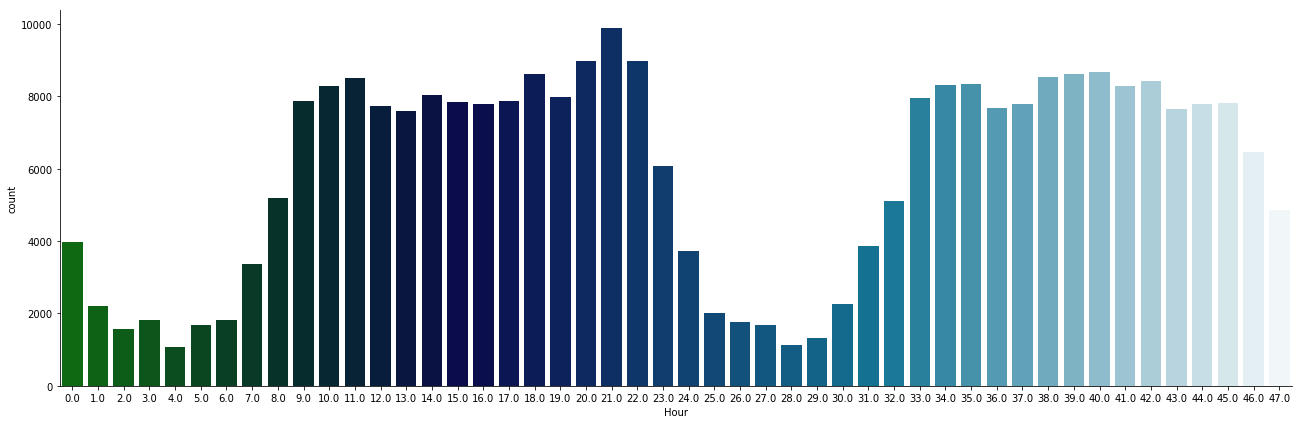

In [4]:

sns.factorplot(x="Hour", data=data, kind="count",  palette="ocean", size=6, aspect=3)

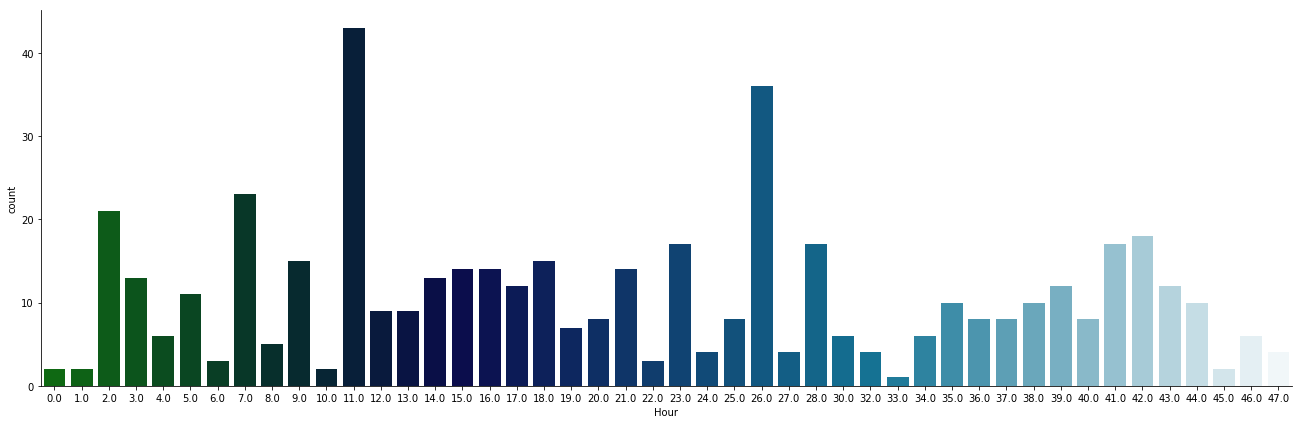

In [5]:
sns.factorplot(x="Hour", data=data[data['Class']==1], kind="count",  palette="ocean", size=6, aspect=3)

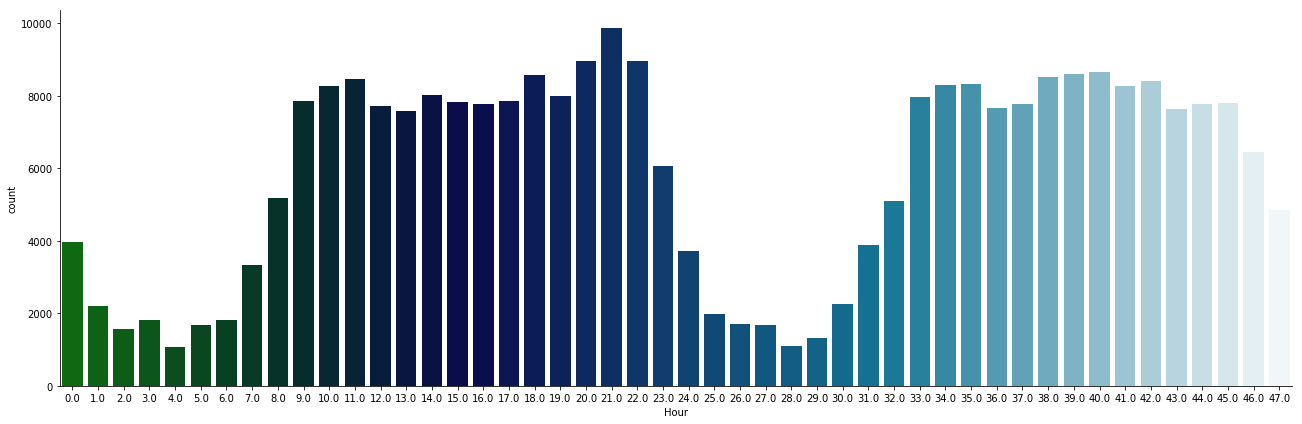

In [6]:
sns.factorplot(x="Hour", data=data[data['Class']==0], kind="count",  palette="ocean", size=6, aspect=3)

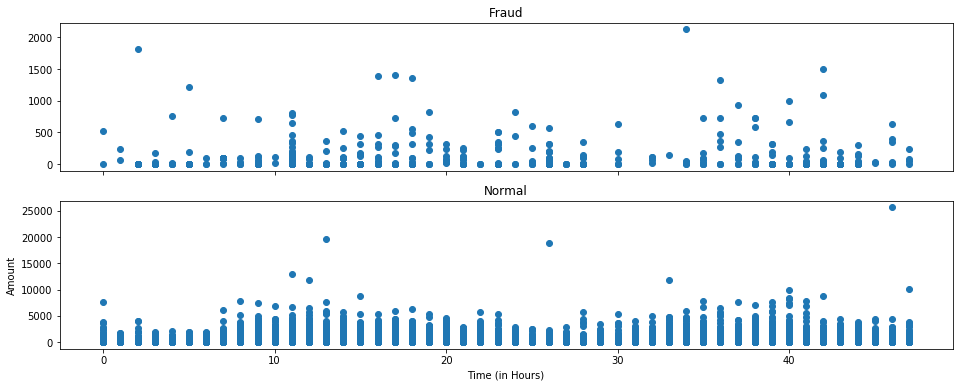

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,6))

ax1.scatter(data["Hour"][data["Class"] == 1], data["Amount"][data["Class"]  == 1])
ax1.set_title('Fraud')

ax2.scatter(data["Hour"][data["Class"] == 0], data["Amount"][data["Class"] == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Hours)')
plt.ylabel('Amount')
plt.show()

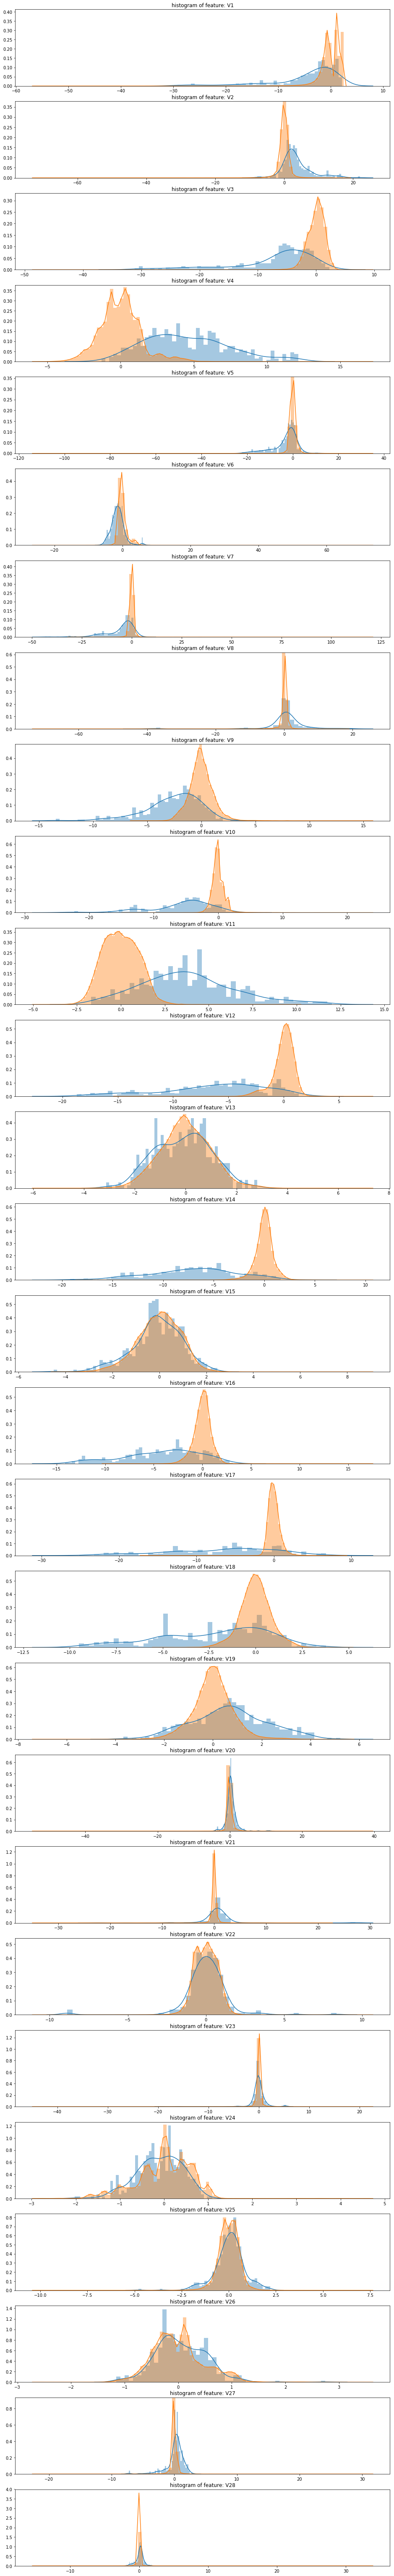

In [8]:
import matplotlib.gridspec as gridspec

v_feat = data.ix[:,1:-3].columns
plt.figure(figsize=(16,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(data[v_feat]):
    ax = plt.subplot(gs[i])
    sns.distplot(data[cn][data["Class"] == 1], bins=50)
    sns.distplot(data[cn][data["Class"] == 0], bins=100)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))



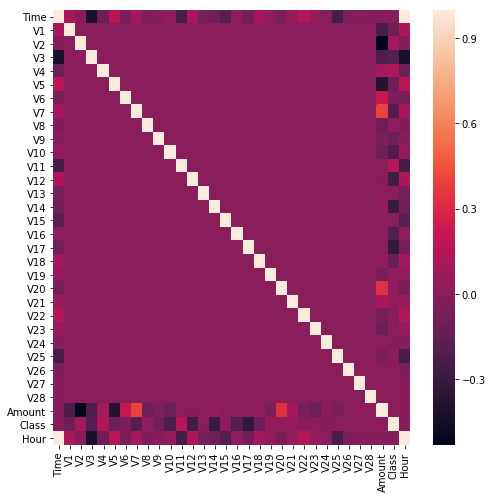

In [9]:
#Plotting a heatmap to visualize the correlation between the variables
plt.figure(figsize=(8,8))
sns.heatmap(data.corr())

In [45]:
droplist = [ 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28','Time']
#droplist = [ 'V13', 'V15',  'V22', 'V24', 'V25']
data_new = data.drop(droplist, axis = 1)
data_new.shape 

(284807, 19)

In [47]:
from sklearn.preprocessing import StandardScaler

col = ['Amount']
sc =StandardScaler() 
data_new[col] =sc.fit_transform(data_new[col])



In [48]:
data = data_new



The total number of class 0 is:  284315
The total number of class 1 is:  492
Class 0 ratio:  0.998272514369
Class 1 ratio:  0.00172748563062


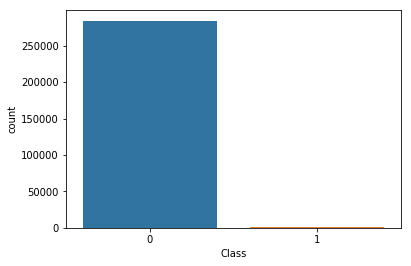

In [49]:
sns.countplot(data['Class'])
print('The total number of class 0 is: ', sum(data['Class']==0))
print('The total number of class 1 is: ', sum(data['Class']==1))
print('Class 0 ratio: ', sum(data['Class']==0)/data.shape[0])
print('Class 1 ratio: ', sum(data['Class']==1)/data.shape[0])

### 1. undersample

In [50]:
fraud_indices= np.array(data[data['Class']==1].index)
normal_indices = np.array(data[data['Class']==0].index)
random_normal_indices = np.random.choice(normal_indices, len(fraud_indices), replace = False)

undersample_indices = np.concatenate([fraud_indices,random_normal_indices])
undersample_data = data.iloc[undersample_indices,:]
undersample_X =  undersample_data.ix[:, undersample_data.columns != 'Class']
undersample_y = undersample_data.ix[:, undersample_data.columns == 'Class']

In [51]:
##make y as one dimension vector for GridSearchCV.fit
c, r = undersample_y.shape
undersample_y = undersample_y.values.reshape(c,)

In [52]:
print('No. of undersample X :', len(undersample_X), '; No. of undersample y :', len(undersample_y))

No. of undersample X : 984 ; No. of undersample y : 984


In [53]:
from sklearn.cross_validation import train_test_split

X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(undersample_X,undersample_y,test_size = 0.3,random_state = 0)
print(len(X_train_undersample))

688


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,f1_score, precision_score

C_params = [0.01, 0.1, 1, 10, 100]
params_grid = dict(C=C_params)


lr = LogisticRegression()
grid = GridSearchCV(lr, params_grid, cv=10, scoring='recall')

grid.fit(X_train_undersample, y_train_undersample)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='recall', verbose=0)

In [55]:
grid.grid_scores_

[mean: 0.93048, std: 0.03853, params: {'C': 0.01},
 mean: 0.91304, std: 0.04598, params: {'C': 0.1},
 mean: 0.91304, std: 0.04598, params: {'C': 1},
 mean: 0.91013, std: 0.04672, params: {'C': 10},
 mean: 0.91013, std: 0.04692, params: {'C': 100}]

In [58]:
grid.grid_scores_C_params = [0.01, 0.1, 1, 10, 100]
params_grid = dict(C=C_params)


lr = LogisticRegression()
grid = GridSearchCV(lr, params_grid, cv=10, scoring='average_precision')

grid.fit(X_train_undersample, y_train_undersample)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='average_precision', verbose=0)

In [59]:
grid.grid_scores_

[mean: 0.98606, std: 0.00737, params: {'C': 0.01},
 mean: 0.98651, std: 0.00652, params: {'C': 0.1},
 mean: 0.98581, std: 0.00638, params: {'C': 1},
 mean: 0.98465, std: 0.00619, params: {'C': 10},
 mean: 0.98470, std: 0.00585, params: {'C': 100}]

In [72]:
best_c = 0.01

In [73]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test.
lr = LogisticRegression(C = best_c)
lr.fit(X_train_undersample,y_train_undersample)
y_pred_undersample = lr.predict(X_test_undersample)

Confusion matrix, without normalization
[[145   4]
 [ 10 137]]
Normalized confusion matrix
[[ 0.97315436  0.02684564]
 [ 0.06802721  0.93197279]]


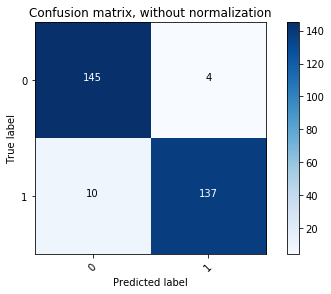

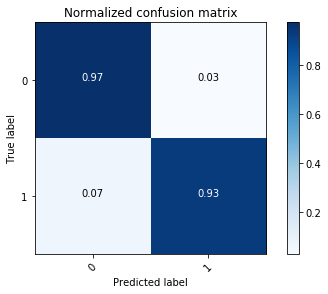

In [74]:
import itertools

cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [75]:
#print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
print("Recall metric in the testing dataset: ",recall_score(y_test_undersample,y_pred_undersample))
print("precision metric in the testing dataset: ",precision_score(y_test_undersample,y_pred_undersample))

Recall metric in the testing dataset:  0.931972789116
precision metric in the testing dataset:  0.971631205674


In [76]:
 # Whole dataset
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

Confusion matrix, without normalization
[[83009  2287]
 [   13   134]]
Normalized confusion matrix
[[ 0.97318749  0.02681251]
 [ 0.08843537  0.91156463]]


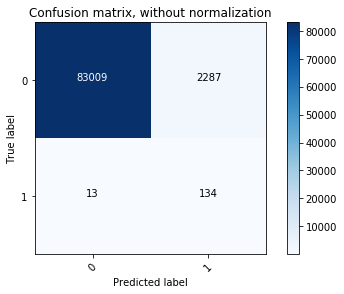

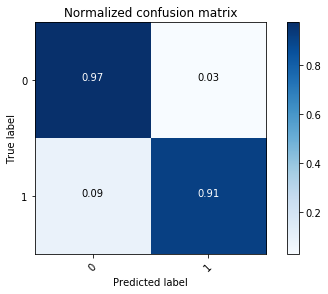

Recall metric in the testing dataset:  0.91156462585
precision metric in the testing dataset:  0.0553490293267
Average Precision(~AUCPRC) metric in the testing dataset:  0.0506063654252


In [92]:
#Use this C_parameter 0.01 to build the final model with the whole training dataset and predict the classes in the test
y_pred = lr.predict(X_test)

cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
print("Recall metric in the testing dataset: ",recall_score(y_test,y_pred))
print("precision metric in the testing dataset: ",precision_score(y_test,y_pred))
average_precision_whole = average_precision_score(y_test,y_pred)
print("Average Precision(~AUCPRC) metric in the testing dataset: ", average_precision_whole)



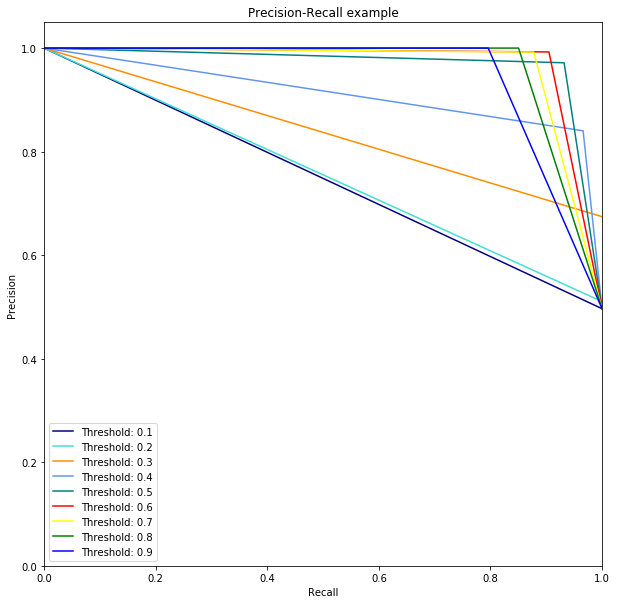

In [78]:
from itertools import cycle

lr.fit(X_train_undersample,y_train_undersample)
y_pred_undersample_proba = lr.predict_proba(X_test_undersample)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(10,10))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

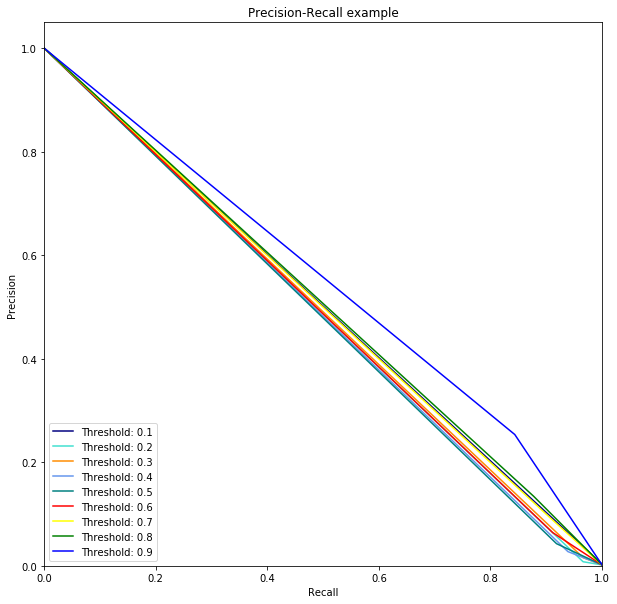

In [94]:
from itertools import cycle

lr.fit(X_train_undersample,y_train_undersample)
y_pred_undersample_proba = lr.predict_proba(X_test)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(10,10))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

In [80]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
columns = X_train.columns
X_oversample,y_oversample=sm.fit_sample(X_train,y_train)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [81]:
X_oversample = pd.DataFrame(data=X_oversample,columns=columns )
y_oversample= pd.DataFrame(data=y_oversample,columns=["Class"])

In [82]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_oversample,y_oversample,test_size = 0.3,random_state = 0)

In [83]:
c, r = y_train_smote.shape
y_train_smote = y_train_smote.values.reshape(c,)

C_params = [0.01, 0.1, 1, 10, 100]
params_grid = dict(C=C_params)


lr = LogisticRegression()
grid = GridSearchCV(lr, params_grid, cv=10, scoring='recall')

grid.fit(X_train_smote, y_train_smote)
print('C for recall score: ', grid.grid_scores_)

grid = GridSearchCV(lr, params_grid, cv=10, scoring='average_precision')

grid.fit(X_train_smote, y_train_smote)
print('C for average_precision score: ',grid.grid_scores_)




C for recall score:  [mean: 0.90606, std: 0.00356, params: {'C': 0.01}, mean: 0.90664, std: 0.00351, params: {'C': 0.1}, mean: 0.90670, std: 0.00350, params: {'C': 1}, mean: 0.90670, std: 0.00350, params: {'C': 10}, mean: 0.90670, std: 0.00350, params: {'C': 100}]
C for average_precision score:  [mean: 0.98960, std: 0.00044, params: {'C': 0.01}, mean: 0.98960, std: 0.00044, params: {'C': 0.1}, mean: 0.98960, std: 0.00044, params: {'C': 1}, mean: 0.98960, std: 0.00044, params: {'C': 10}, mean: 0.98960, std: 0.00044, params: {'C': 100}]


In [84]:
best_c = 0.1

In [85]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test.
lr = LogisticRegression(C = best_c)
lr.fit(X_train_smote,y_train_smote)
y_pred_smote = lr.predict(X_test_smote)

Confusion matrix, without normalization
[[58363  1688]
 [ 5450 53911]]
Normalized confusion matrix
[[ 0.97189056  0.02810944]
 [ 0.09181112  0.90818888]]


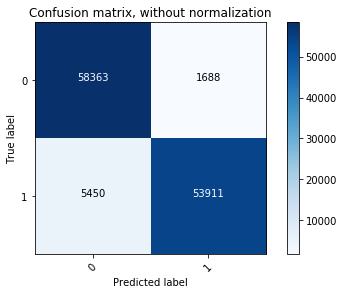

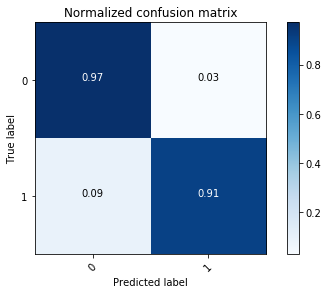

In [86]:
cnf_matrix = confusion_matrix(y_test_smote,y_pred_smote)

#Draw confusion matrix
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [95]:
#print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
print("Recall metric in the testing dataset: ",recall_score(y_test_smote,y_pred_smote))
print("precision metric in the testing dataset: ",precision_score(y_test_smote,y_pred_smote))
average_precision_whole = average_precision_score(y_test_smote,y_pred_smote)
print("Average Precision(~AUCPRC) metric in the testing dataset: ", average_precision_whole)





Recall metric in the testing dataset:  0.90818887822
precision metric in the testing dataset:  0.969639741722
Average Precision(~AUCPRC) metric in the testing dataset:  0.926256333469


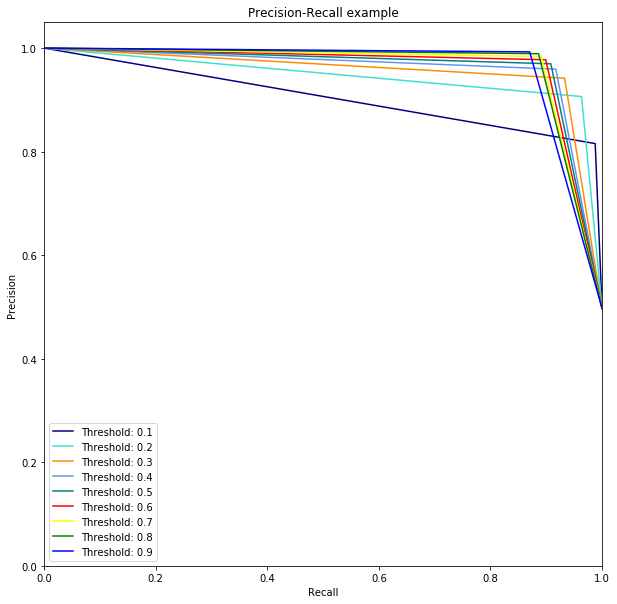

In [88]:
#draw AUCPRC
y_pred_smote_proba = lr.predict_proba(X_test_smote)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(10,10))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_smote_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_smote,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

Confusion matrix, without normalization
[[83009  2287]
 [   13   134]]
Normalized confusion matrix
[[ 0.97318749  0.02681251]
 [ 0.08843537  0.91156463]]


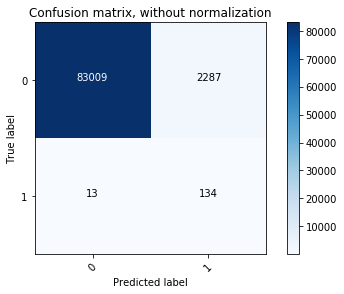

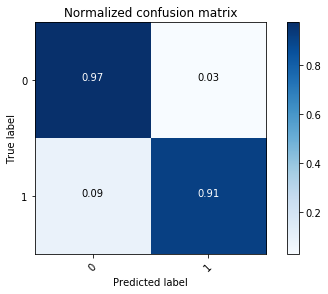

Recall metric in the testing dataset:  0.91156462585
precision metric in the testing dataset:  0.0553490293267


NameError: name 'average_precision_score' is not defined

In [89]:
#use original test dataset to test the model.
y_pred = lr.predict(X_test)

cnf_matrix = confusion_matrix(y_test,y_pred)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
print("Recall metric in the testing dataset: ",recall_score(y_test,y_pred))
print("precision metric in the testing dataset: ",precision_score(y_test,y_pred))
average_precision_whole = average_precision_score(y_test,y_pred)
print("Average Precision(~AUCPRC) metric in the testing dataset: ", average_precision_whole)





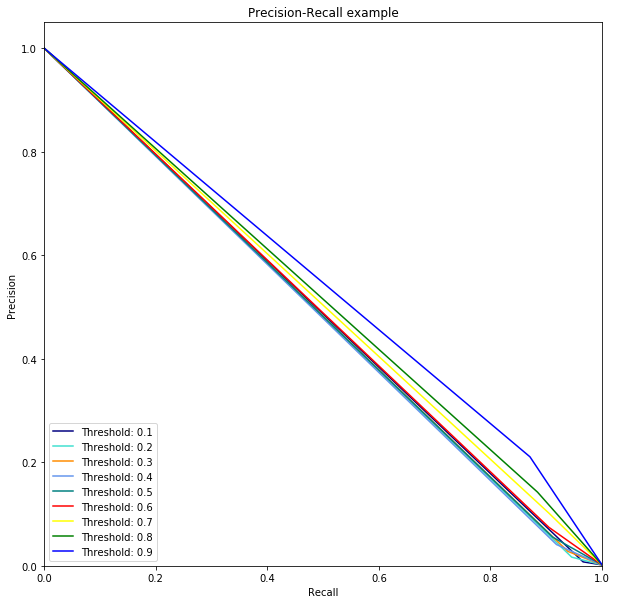

In [90]:
y_pred_proba = lr.predict_proba(X_test)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(10,10))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")